In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import warnings
import numpy as np
import seaborn as sns 
import lightgbm as lgb
from itertools import cycle
from sklearn.svm import SVR
import statsmodels.api as sm
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import plotly.graph_objects as go
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import plotly.express as px
import lightgbm as lgb
from catboost import CatBoostRegressor
from collections import defaultdict
from statsmodels.tsa.stattools import adfuller

In [ ]:
# загрузка данных
data = pd.read_excel('Neftebaza.xlsx')
data.head(25)

In [ ]:
data['Дата'].iloc[2] 

Timestamp('2022-01-01 00:00:00')

In [ ]:
# заменим 24 на 0 в колонке часы
# создадим функцию
def mod_midnight(t):
    if t == 24:
        t = 0
    return t



# применим функцию
data.loc[(data['часы'] == 24), 'Дата'] = data.loc[(data['часы'] == 24), 'Дата'] + timedelta(days=1)

data['часы'] = data['часы'].apply(mod_midnight)



# преобразуем значения колонок 'Дата', 'часы' в строку
data['Дата'] = data['Дата'].astype(str)
data['часы'] = data['часы'].astype(str)

# создадим новую колонку 
data['date'] = data['Дата'] + "-" + data['часы']
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d-%H')

In [ ]:
# возьмем необходимые колонки для дальнейшей работы
data_clean = data[['date', 'Потребитель']]

In [ ]:
# сохраним преобразованный датасет
data_clean.to_excel("data_clean.xlsx", index=False)

In [ ]:
fig = px.line(x=data_clean['date'], y=data_clean['Потребитель'], labels={'x':'Время', 'y':'Потребление'}, width=800, height=400)
fig.show()

In [ ]:
# загрузка данных
data = pd.read_excel('data_clean.xlsx')
data.head()

,date,Потребитель
0,2022-01-01 01:00:00,38.4
1,2022-01-01 02:00:00,40.5
2,2022-01-01 03:00:00,40.2
3,2022-01-01 04:00:00,36.6
4,2022-01-01 05:00:00,39.9


In [ ]:
data["hour"] = data['date'].apply(lambda x: x.hour)
data["weekday"] = data['date'].apply(lambda x: x.weekday())

In [ ]:

def lags_windows(df):
    lags = [24]
    lag_cols = ["lag_{}".format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df["Потребитель"].shift(lag)

    wins = [8]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df["rmean_{}_{}".format(lag,win)] = df[lag_col].transform(lambda x : x.rolling(win).mean())   
    return df

def feat_eng(df):
    df = lags_windows(df)
    return df

In [ ]:
def lags_windows_1(df):
    lags = [1]
    lag_cols = ["lag_{}".format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df["Потребитель"].shift(lag)

    wins = [3]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df["rmean_{}_{}".format(lag,win)] = df[lag_col].transform(lambda x : x.rolling(win).mean())   
    return df

def feat_eng_1(df):
    df = lags_windows_1(df)
    return df

In [ ]:
def lags_windows_2(df):
    lags = [3]
    lag_cols = ["lag_{}".format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df["Потребитель"].shift(lag)

    wins = [5]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df["rmean_{}_{}".format(lag,win)] = df[lag_col].transform(lambda x : x.rolling(win).mean())   
    return df

def feat_eng_2(df):
    df = lags_windows_2(df)
    return df

In [ ]:
data = pd.read_excel('data_clean.xlsx')
data["hour"] = data['date'].apply(lambda x: x.hour)
data["weekday"] = data['date'].apply(lambda x: x.weekday())

hours_predict = 24*7

train, test = train_test_split(data, train_size = 1 - hours_predict/len(data), shuffle=False)

In [ ]:
data.head()

,date,Потребитель,hour,weekday
0,2022-01-01 01:00:00,38.4,1,5
1,2022-01-01 02:00:00,40.5,2,5
2,2022-01-01 03:00:00,40.2,3,5
3,2022-01-01 04:00:00,36.6,4,5
4,2022-01-01 05:00:00,39.9,5,5


In [ ]:
# новый код
start_time = time.time()
temp = train.copy()
temp_4_pred = temp.copy()
front_predict = len(test)
for i in range(front_predict):
# добавили фичи
  temp_4_fit = temp.copy()
  temp_4_fit = feat_eng(feat_eng_1(feat_eng_2(temp_4_fit)))
  temp_4_fit = temp_4_fit.dropna()
  temp_4_fit = temp_4_fit.reset_index(drop=True)
# подготовили иксы и игрики для модели
  X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
  y_train_4_fit = temp_4_fit['Потребитель']
# протренировали модель
  lr = LinearRegression()
  lr.fit(X_train_4_fit, y_train_4_fit)
# создаём следуюущее значение которое надо предсказать
# создадим новую строку, в основном, надо чтобы была добавлена дата на час вперед, остальные знаения будут в нуле
   
  temp_4_pred.loc[len(temp_4_pred), 'date'] = temp_4_pred['date'].iloc[-1] + timedelta(hours=1)
  temp_4_pred.loc[len(temp_4_pred), 'Потребитель'] = np.nan
  temp_4_pred["hour"] = temp_4_pred['date'].apply(lambda x: x.hour)
  temp_4_pred["weekday"] = temp_4_pred['date'].apply(lambda x: x.weekday())
  temp_4_pred = feat_eng(feat_eng_1(feat_eng_2(temp_4_pred)))
  temp_4_pred = temp_4_pred[:-1]
# на данном этапе имеем датафрейм с одной добавленной строкой и одни пустым значением в искомом столбце
# выделим строку для предсказания
  value_4_pred = temp_4_pred.tail(1)
  X_train_4_pred = value_4_pred.drop(['Потребитель', 'date'], axis = 1)
  X_train_4_pred = X_train_4_pred.fillna(0)
# предсказываем значение
  predict_consumer = lr.predict(X_train_4_pred)
  temp_4_pred.loc[len(temp_4_pred)-1, 'Потребитель'] = float(predict_consumer)
  temp = temp_4_pred.copy()
final_proverka = temp_4_pred.copy()  
final = temp_4_pred.copy().loc[len(final_proverka)-front_predict:][['date', 'Потребитель']]
time_lr = time.time() - start_time

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train['date'], y=train['Потребитель'],
                    mode='lines',
                    name='Train'))
fig.add_trace(go.Scatter(x=test['date'], y=test['Потребитель'],
                    mode='lines',
                    name='test'))
fig.add_trace(go.Scatter(x=final['date'], y=final['Потребитель'],
                    mode='lines',
                    name='predict'))

fig.show()

In [ ]:
y_test = test['Потребитель']
pred_lr = final['Потребитель']
df_rmse_rrmse = pd.DataFrame(data = {'Модель' : 'Linear Regression', 'RMSE' :
                                     [round(mean_squared_error(y_test, pred_lr, squared=False), 1)],
                                      'MAE' : [round(mean_absolute_error(y_test, pred_lr), 1)] ,
                                      'Промежуток прогнозирования' : 'Неделя', 'Дискретность' : 'Часы',
                                      "Время выполнения, c": [round(time_lr, 2)]})

In [ ]:
df_rmse_rrmse

,Модель,RMSE,MAE,Промежуток прогнозирования,Дискретность,"Время выполнения, c"
0,Linear Regression,20.8,17.7,Неделя,Часы,14.17


##LGBM

In [ ]:
temp = train.copy()
params = {'n_estimators' : list(range(50,105,5)), 'max_depth' : list(range(5,11)), 'min_samples_split' : list(range(2,6)), 'min_samples_leaf' : list(range(1,6))}

temp_4_fit = temp.copy()
temp_4_fit = feat_eng(feat_eng_1(feat_eng_2(temp_4_fit)))
temp_4_fit = temp_4_fit.dropna()
temp_4_fit = temp_4_fit.reset_index(drop=True)
X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
y_train_4_fit = temp_4_fit['Потребитель']

lgbm = LGBMRegressor()

gs_reg = GridSearchCV(lgbm, params, cv = TimeSeriesSplit(n_splits=4).split(X_train_4_fit))
gs_reg.fit(X_train_4_fit, y_train_4_fit)
best_lgb = gs_reg.best_estimator_

In [ ]:
start_time = time.time()
temp = train.copy()
temp_4_pred = temp.copy()
front_predict = len(test)
for i in range(front_predict):

  temp_4_fit = temp.copy()
  temp_4_fit = feat_eng(feat_eng_1(feat_eng_2(temp_4_fit)))
  temp_4_fit = temp_4_fit.dropna()
  temp_4_fit = temp_4_fit.reset_index(drop=True)
  X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
  y_train_4_fit = temp_4_fit['Потребитель']

  best_lgb.fit(X_train_4_fit, y_train_4_fit)

  temp_4_pred.loc[len(temp_4_pred), 'date'] = temp_4_pred['date'].iloc[-1] + timedelta(hours=1)
  temp_4_pred.loc[len(temp_4_pred), 'Потребитель'] = np.nan
  temp_4_pred["hour"] = temp_4_pred['date'].apply(lambda x: x.hour)
  temp_4_pred["weekday"] = temp_4_pred['date'].apply(lambda x: x.weekday())
  temp_4_pred = feat_eng(feat_eng_1(feat_eng_2(temp_4_pred)))
  temp_4_pred = temp_4_pred[:-1]

  value_4_pred = temp_4_pred.tail(1)
  X_train_4_pred = value_4_pred.drop(['Потребитель', 'date'], axis = 1)
  X_train_4_pred = X_train_4_pred.fillna(0)

  predict_consumer = best_lgb.predict(X_train_4_pred)
  temp_4_pred.loc[len(temp_4_pred)-1, 'Потребитель'] = float(predict_consumer)
  temp = temp_4_pred.copy()
final_lgbm = temp_4_pred.copy()  
final_lgbm = temp_4_pred.copy().loc[len(final_lgbm)-front_predict:][['date', 'Потребитель']]
time_lgbm = time.time() - start_time

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train['date'], y=train['Потребитель'],
                    mode='lines',
                    name='Train'))
fig.add_trace(go.Scatter(x=test['date'], y=test['Потребитель'],
                    mode='lines',
                    name='test'))
fig.add_trace(go.Scatter(x=final_lgbm['date'], y=final['Потребитель'],
                    mode='lines',
                    name='predict'))

fig.show()

In [ ]:
y_test = test['Потребитель']
pred_lgbm = final_lgbm['Потребитель']

df_rmse_rrmse = df_rmse_rrmse.append(pd.DataFrame(data = {'Модель' : 'LGBM', 'RMSE' :
                                     [round(mean_squared_error(y_test, pred_lgbm, squared=False), 1)],
                                      'MAE' : [round(mean_absolute_error(y_test, pred_lgbm), 1)] ,
                                      'Промежуток прогнозирования' : 'Неделя', 'Дискретность' : 'Часы',
                                      "Время выполнения, c": [round(time_lgbm, 2)]}))

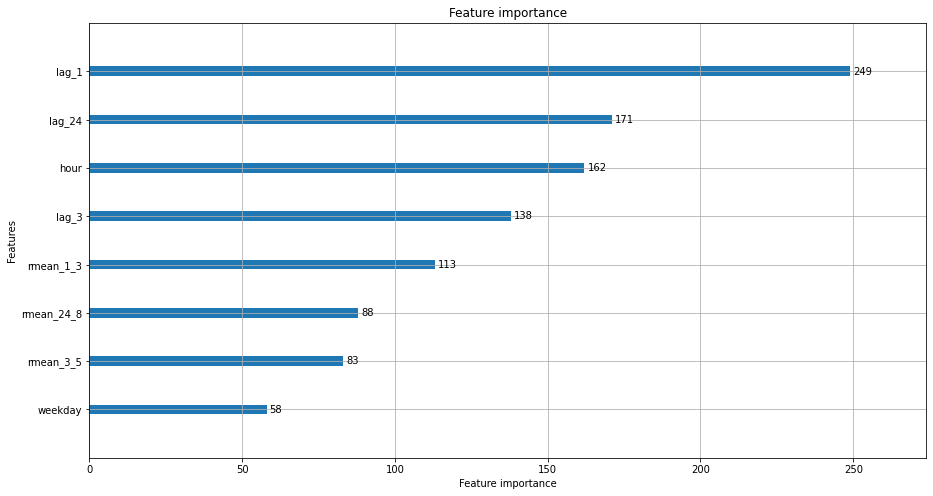

In [ ]:
lgb.plot_importance(best_lgb, figsize=(15, 8))

In [ ]:
df_rmse_rrmse 

,Модель,RMSE,MAE,Промежуток прогнозирования,Дискретность,"Время выполнения, c"
0,Linear Regression,21.0,17.8,Неделя,Часы,9.14
0,LGBM,24.0,20.8,Неделя,Часы,12.40


#Catboost

In [ ]:
temp = train.copy()
params = {'n_estimators' : list(range(50,105,5)), 'max_depth' : list(range(5,11))}

temp_4_fit = temp.copy()
temp_4_fit = feat_eng(feat_eng_1(temp_4_fit))
temp_4_fit = temp_4_fit.dropna()
temp_4_fit = temp_4_fit.reset_index(drop=True)
X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
y_train_4_fit = temp_4_fit['Потребитель']

Catbooster = CatBoostRegressor(random_state=123, silent=True)

gs_reg_cat = GridSearchCV(Catbooster, params, cv = TimeSeriesSplit(n_splits=4).split(X_train_4_fit))
gs_reg_cat.fit(X_train_4_fit, y_train_4_fit)
best_catboost = gs_reg_cat.best_estimator_

In [ ]:
start_time = time.time()
temp = train.copy()
temp_4_pred = temp.copy()
front_predict = len(test)
for i in range(front_predict):

  temp_4_fit = temp.copy()
  temp_4_fit = feat_eng(feat_eng_1(temp_4_fit))
  temp_4_fit = temp_4_fit.dropna()
  temp_4_fit = temp_4_fit.reset_index(drop=True)
  X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
  y_train_4_fit = temp_4_fit['Потребитель']

  best_catboost.fit(X_train_4_fit, y_train_4_fit)

  temp_4_pred.loc[len(temp_4_pred), 'date'] = temp_4_pred['date'].iloc[-1] + timedelta(hours=1)
  temp_4_pred.loc[len(temp_4_pred), 'Потребитель'] = np.nan
  temp_4_pred["hour"] = temp_4_pred['date'].apply(lambda x: x.hour)
  temp_4_pred["weekday"] = temp_4_pred['date'].apply(lambda x: x.weekday())
  temp_4_pred = feat_eng(feat_eng_1(temp_4_pred))
  temp_4_pred = temp_4_pred[:-1]

  value_4_pred = temp_4_pred.tail(1)
  X_train_4_pred = value_4_pred.drop(['Потребитель', 'date'], axis = 1)
  X_train_4_pred = X_train_4_pred.fillna(0)

  predict_consumer = best_lgb.predict(X_train_4_pred)
  temp_4_pred.loc[len(temp_4_pred)-1, 'Потребитель'] = float(predict_consumer)
  temp = temp_4_pred.copy()
final_catboost = temp_4_pred.copy()  
final_catboost = temp_4_pred.copy().loc[len(final_catboost)-front_predict:][['date', 'Потребитель']]
time_cattboost = time.time() - start_time

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train['date'], y=train['Потребитель'],
                    mode='lines',
                    name='Train'))
fig.add_trace(go.Scatter(x=test['date'], y=test['Потребитель'],
                    mode='lines',
                    name='test'))
fig.add_trace(go.Scatter(x=final_catboost['date'], y=final_catboost['Потребитель'],
                    mode='lines',
                    name='predict'))

fig.show()

In [ ]:
y_test = test['Потребитель']
pred_catboost = final_catboost['Потребитель']
df_rmse_rrmse = df_rmse_rrmse.append(pd.DataFrame(data = {'Модель' : 'CatBoost', 'RMSE' :
                                     [round(mean_squared_error(y_test, pred_catboost, squared=False), 1)],
                                      'MAE' : [round(mean_absolute_error(y_test, pred_catboost), 1)] ,
                                      'Промежуток прогнозирования' : 'Неделя', 'Дискретность' : 'Часы',
                                      "Время выполнения, c": [round(time_cattboost, 2)]}))

In [ ]:
df_rmse_rrmse

,Модель,RMSE,MAE,Промежуток прогнозирования,Дискретность,"Время выполнения, c"
0,Linear Regression,21.0,17.8,Неделя,Часы,9.14
0,LGBM,24.0,20.8,Неделя,Часы,12.40
0,CatBoost,23.4,20.5,Неделя,Часы,38.69
